## Setting Up Your Python Environment

In [1]:
# %%capture
# # Install PyTorch
# !pip install torch torchvision torchaudio

# # Install additional dependencies
# !pip install matplotlib pandas pillow tqdm

# # Install package for creating visually distinct colormaps
# !pip install distinctipy

# # Install utility packages
# !pip install cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [2]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Loading and Exploring the Dataset

### Setting the Directory Paths

In [3]:
# Define path to store datasets
dataset_dir = Path("./Datasets/")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,Datasets
Archive Directory:,Datasets/../Archive


### Setting the Dataset Path

In [4]:
# Set the name of the dataset
dataset_name = 'labelme-instance-segmentation-toy-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
hf_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "HuggingFace Dataset:": hf_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

HuggingFace Dataset:,cj-mills/labelme-instance-segmentation-toy-dataset
Archive Path:,Datasets/../Archive/labelme-instance-segmentation-toy-dataset.zip
Dataset Path:,Datasets/labelme-instance-segmentation-toy-dataset


### Downloading the Dataset

In [5]:
# Construct the HuggingFace Hub dataset URL
dataset_url = f"https://huggingface.co/datasets/{hf_dataset}/resolve/main/{dataset_name}.zip"
print(f"HuggingFace Dataset URL: {dataset_url}")

# Set whether to delete the archive file after extracting the dataset
delete_archive = True

# Download the dataset if not present
if dataset_path.is_dir():
    print("Dataset folder already exists")
else:
    print("Downloading dataset...")
    download_file(dataset_url, archive_dir)    
    
    print("Extracting dataset...")
    file_extract(fname=archive_path, dest=dataset_dir)
    
    # Delete the archive if specified
    if delete_archive: archive_path.unlink()

HuggingFace Dataset URL: https://huggingface.co/datasets/cj-mills/labelme-instance-segmentation-toy-dataset/resolve/main/labelme-instance-segmentation-toy-dataset.zip


  0%|          | 0.00/18.0M [00:00<?, ?iB/s]

Extracting dataset...


### Getting the Image and Annotation Files

In [6]:
# Get a list of image files in the dataset
img_file_paths = get_img_files(dataset_path)

# Get a list of JSON files in the dataset
annotation_file_paths = list(dataset_path.glob('*.json'))

# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image File": [file.name for file in img_file_paths], 
              "Annotation File":[file.name for file in annotation_file_paths]}).head()

,Image File,Annotation File
0,balloon-launch-festival-flame-1426050.jpg,baby-bridge-carrying-1157393.json
1,bar-beer-celebration-3009788.jpg,balloon-launch-festival-flame-1426050.json
2,beach-child-daughter-1438511.jpg,bar-beer-celebration-3009788.json
3,cellphone-festival-girl-1408983.jpg,beach-child-daughter-1438511.json
4,chair-indoors-man-2253869.jpg,cellphone-festival-girl-1408983.json


### Get Image File Paths

In [7]:
# Create a dictionary that maps file names to file paths
img_dict = {file.stem : file for file in img_file_paths}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head()

Number of Images: 31


,0
balloon-launch-festival-flame-1426050,Datasets/labelme-instance-segmentation-toy-dataset/balloon-launch-festival-flame-1426050.jpg
bar-beer-celebration-3009788,Datasets/labelme-instance-segmentation-toy-dataset/bar-beer-celebration-3009788.jpg
beach-child-daughter-1438511,Datasets/labelme-instance-segmentation-toy-dataset/beach-child-daughter-1438511.jpg
cellphone-festival-girl-1408983,Datasets/labelme-instance-segmentation-toy-dataset/cellphone-festival-girl-1408983.jpg
chair-indoors-man-2253869,Datasets/labelme-instance-segmentation-toy-dataset/chair-indoors-man-2253869.jpg


### Get Image Annotations

In [8]:
# Create a generator that yields Pandas DataFrames containing the data from each JSON file
cls_dataframes = (pd.read_json(f, orient='index').transpose() for f in tqdm(annotation_file_paths))

# Concatenate the DataFrames into a single DataFrame
annotation_df = pd.concat(cls_dataframes, ignore_index=False)

# Assign the image file name as the index for each row
annotation_df['index'] = annotation_df.apply(lambda row: row['imagePath'].split('.')[0], axis=1)
annotation_df = annotation_df.set_index('index')

# Keep only the rows that correspond to the filenames in the 'img_dict' dictionary
annotation_df = annotation_df.loc[list(img_dict.keys())]

# Print the first 5 rows of the DataFrame
annotation_df.head()

  0%|          | 0/31 [00:00<?, ?it/s]

,version,flags,shapes,imagePath,imageData,imageHeight,imageWidth
index,,,,,,,
balloon-launch-festival-flame-1426050,5.3.1,{},"[{'label': 'person', 'points': [[1070.0, 767.0], [767.0, 765.5], [747.5, 760.0], [757.5, 697.0], [777.5, 651.0], [813.5, 598.0], [871.5, 548.0], [861.5, 537.0], [873.5, 501.0], [906.5, 484.0], [902.5, 480.0], [909.5, 466.0], [911.5, 406.0], [941.0, 379.5], [990.0, 375.5], [1017.0, 388.5], [1033.5, 407.0], [1036.5, 439.0], [998.5, 517.0], [1012.0, 537.5], [1024.0, 541.5], [1043.5, 561.0], [1061.5, 590.0], [1078.5, 641.0], [1083.5, 728.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[752.0, 687.5], [749.5, 687.0], [745.5, 675.0], [733.5, 668.0], [737.5, 636.0], [737.5, 613.0], [743.5, 594.0], [753.5, 584.0], [754.5, 578.0], [759.5, 570.0], [760.5, 553.0], [769.0, 546.5], [777.0, 545.5], [785.5, 552.0], [788.5, 561.0], [790.5, 575.0], [786.5, 592.0], [794.5, 605.0], [794.5, 618.0], [793.5, 622.0], [777.5, 643.0], [767.5, 669.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[189.0, 727.5], [182.0, 727.5], [178.0, 721.5], [171.0, 720.5], [167.5, 717.0], [165.5, 703.0], [168.5, 699.0], [166.0, 696.5], [155.5, 695.0], [155.5, 680.0], [160.5, 648.0], [163.5, 640.0], [174.5, 629.0], [176.5, 615.0], [179.5, 608.0], [186.0, 603.5], [193.0, 603.5], [201.5, 610.0], [199.5, 635.0], [204.5, 648.0], [206.5, 700.0], [202.0, 703.5], [196.0, 699.5], [193.5, 700.0], [193.5, 717.0], [191.5, 725.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[689.0, 724.5], [679.5, 721.0], [667.5, 699.0], [665.5, 662.0], [667.5, 642.0], [656.5, 635.0], [656.5, 631.0], [668.5, 611.0], [668.5, 596.0], [678.0, 584.5], [683.5, 583.0], [682.0, 579.5], [674.0, 580.5], [668.5, 578.0], [666.5, 569.0], [673.0, 562.5], [684.0, 563.5], [688.5, 568.0], [690.5, 582.0], [700.0, 587.5], [703.5, 595.0], [700.5, 643.0], [686.5, 676.0], [686.5, 686.0], [691.5, 695.0], [695.5, 712.0], [693.5, 722.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[482.0, 649.5], [476.0, 648.5], [467.0, 639.5], [455.0, 632.5], [415.0, 627.5], [412.5, 625.0], [411.5, 611.0], [408.0, 608.5], [396.0, 611.5], [386.0, 618.5], [381.0, 617.5], [373.5, 611.0], [374.5, 606.0], [386.5, 587.0], [402.0, 569.5], [421.0, 551.5], [435.0, 551.5], [439.5, 548.0], [439.5, 539.0], [446.0, 524.5], [455.0, 528.5], [459.0, 533.5], [470.0, 537.5], [472.5, 542.0], [472.5, 549.0], [494.5, 564.0], [502.5, 576.0], [507.5, 595.0], [514.5, 604.0], [513.5, 616.0], [511.0, 618.5], [505.0, 618.5], [496.0, 613.5], [492.0, 613.5], [487.5, 617.0], [485.5, 623.0], [486.5, 645.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[258.0, 727.5], [252.0, 726.5], [248.5, 722.0], [247.5, 698.0], [251.5, 685.0], [251.5, 670.0], [245.5, 644.0], [245.5, 624.0], [240.5, 612.0], [240.5, 593.0], [242.5, 587.0], [249.5, 580.0], [249.5, 561.0], [256.0, 552.5], [261.0, 551.5], [271.5, 559.0], [274.5, 576.0], [285.5, 589.0], [285.5, 600.0], [274.5, 634.0], [271.5, 693.0], [265.5, 707.0], [263.5, 722.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[1139.0, 649.5], [1135.0, 649.5], [1132.5, 647.0], [1131.5, 643.0], [1131.5, 625.0], [1129.5, 619.0], [1128.5, 603.0], [1124.5, 592.0], [1125.5, 590.0], [1124.5, 583.0], [1126.5, 575.0], [1132.0, 569.5], [1134.5, 569.0], [1136.5, 559.0], [1140.0, 556.5], [1143.0, 556.5], [1146.5, 560.0], [1146.5, 569.0], [1150.0, 572.5], [1151.0, 573.0], [1151.0, 641.0], [1147.0, 646.5]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}]",balloon-launch-festival-flame-1426050.jpg,None,768,1152
bar-beer-celebration-3009788,5.3.1,{},"[{'label': 'person', 'points': [[725.0, 739.5], [704.0, 732.5], [679.5, 706.0

### Inspecting the Class Distribution

#### Get image classes

In [9]:
# Explode the 'shapes' column in the annotation_df dataframe
# Convert the resulting series to a dataframe and rename the 'shapes' column to 'shapes'
# Apply the pandas Series function to the 'shapes' column of the dataframe
shapes_df = annotation_df['shapes'].explode().to_frame().shapes.apply(pd.Series)

# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = shapes_df['label'].unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,person
1,car


#### Visualize the class distribution

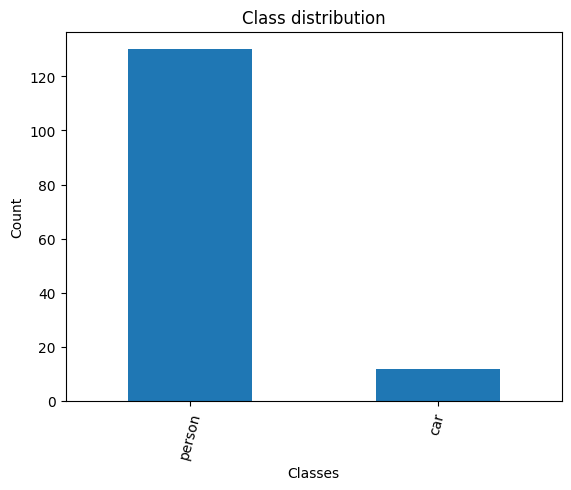

In [10]:
# Get the number of samples for each object class
class_counts = shapes_df['label'].value_counts()

# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_counts.index, rotation=75)  # Set the x-axis tick labels
plt.show()

### Visualizing Image Annotations

#### Generate a color map

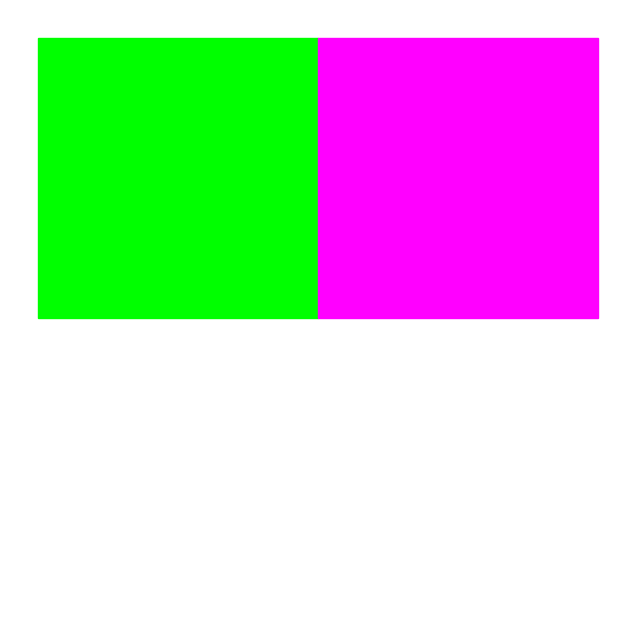

In [11]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

#### Download a font file

In [12]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


#### Define the bounding box annotation function

In [13]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

### Selecting a Sample Image

#### Load the sample image

Image Dims: (1152, 768)


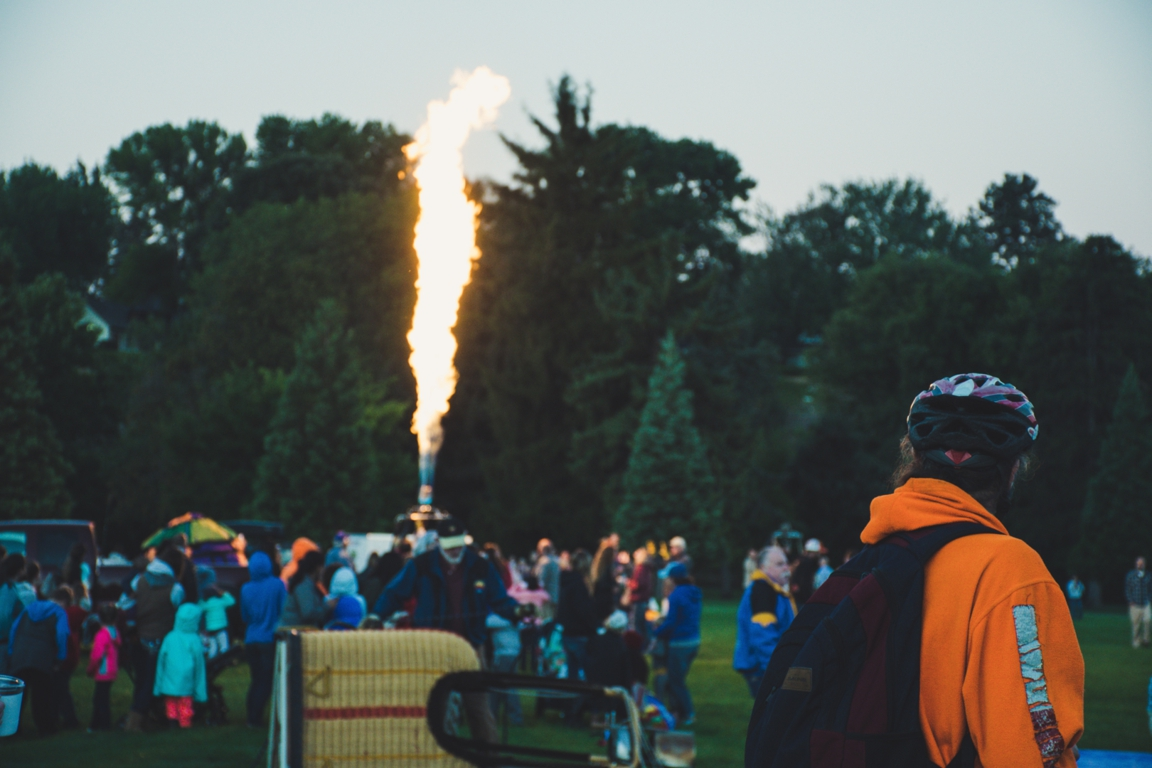

In [14]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict[file_id]).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

#### Inspect the corresponding annotation data

In [15]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc[file_id].to_frame()

,balloon-launch-festival-flame-1426050
version,5.3.1
flags,{}
shapes,"[{'label': 'person', 'points': [[1070.0, 767.0], [767.0, 765.5], [747.5, 760.0], [757.5, 697.0], [777.5, 651.0], [813.5, 598.0], [871.5, 548.0], [861.5, 537.0], [873.5, 501.0], [906.5, 484.0], [902.5, 480.0], [909.5, 466.0], [911.5, 406.0], [941.0, 379.5], [990.0, 375.5], [1017.0, 388.5], [1033.5, 407.0], [1036.5, 439.0], [998.5, 517.0], [1012.0, 537.5], [1024.0, 541.5], [1043.5, 561.0], [1061.5, 590.0], [1078.5, 641.0], [1083.5, 728.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[752.0, 687.5], [749.5, 687.0], [745.5, 675.0], [733.5, 668.0], [737.5, 636.0], [737.5, 613.0], [743.5, 594.0], [753.5, 584.0], [754.5, 578.0], [759.5, 570.0], [760.5, 553.0], [769.0, 546.5], [777.0, 545.5], [785.5, 552.0], [788.5, 561.0], [790.5, 575.0], [786.5, 592.0], [794.5, 605.0], [794.5, 618.0], [793.5, 622.0], [777.5, 643.0], [767.5, 669.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[189.0, 727.5], [182.0, 727.5], [178.0, 721.5], [171.0, 720.5], [167.5, 717.0], [165.5, 703.0], [168.5, 699.0], [166.0, 696.5], [155.5, 695.0], [155.5, 680.0], [160.5, 648.0], [163.5, 640.0], [174.5, 629.0], [176.5, 615.0], [179.5, 608.0], [186.0, 603.5], [193.0, 603.5], [201.5, 610.0], [199.5, 635.0], [204.5, 648.0], [206.5, 700.0], [202.0, 703.5], [196.0, 699.5], [193.5, 700.0], [193.5, 717.0], [191.5, 725.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[689.0, 724.5], [679.5, 721.0], [667.5, 699.0], [665.5, 662.0], [667.5, 642.0], [656.5, 635.0], [656.5, 631.0], [668.5, 611.0], [668.5, 596.0], [678.0, 584.5], [683.5, 583.0], [682.0, 579.5], [674.0, 580.5], [668.5, 578.0], [666.5, 569.0], [673.0, 562.5], [684.0, 563.5], [688.5, 568.0], [690.5, 582.0], [700.0, 587.5], [703.5, 595.0], [700.5, 643.0], [686.5, 676.0], [686.5, 686.0], [691.5, 695.0], [695.5, 712.0], [693.5, 722.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[482.0, 649.5], [476.0, 648.5], [467.0, 639.5], [455.0, 632.5], [415.0, 627.5], [412.5, 625.0], [411.5, 611.0], [408.0, 608.5], [396.0, 611.5], [386.0, 618.5], [381.0, 617.5], [373.5, 611.0], [374.5, 606.0], [386.5, 587.0], [402.0, 569.5], [421.0, 551.5], [435.0, 551.5], [439.5, 548.0], [439.5, 539.0], [446.0, 524.5], [455.0, 528.5], [459.0, 533.5], [470.0, 537.5], [472.5, 542.0], [472.5, 549.0], [494.5, 564.0], [502.5, 576.0], [507.5, 595.0], [514.5, 604.0], [513.5, 616.0], [511.0, 618.5], [505.0, 618.5], [496.0, 613.5], [492.0, 613.5], [487.5, 617.0], [485.5, 623.0], [486.5, 645.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[258.0, 727.5], [252.0, 726.5], [248.5, 722.0], [247.5, 698.0], [251.5, 685.0], [251.5, 670.0], [245.5, 644.0], [245.5, 624.0], [240.5, 612.0], [240.5, 593.0], [242.5, 587.0], [249.5, 580.0], [249.5, 561.0], [256.0, 552.5], [261.0, 551.5], [271.5, 559.0], [274.5, 576.0], [285.5, 589.0], [285.5, 600.0], [274.5, 634.0], [271.5, 693.0], [265.5, 707.0], [263.5, 722.0]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}, {'label': 'person', 'points': [[1139.0, 649.5], [1135.0, 649.5], [1132.5, 647.0], [1131.5, 643.0], [1131.5, 625.0], [1129.5, 619.0], [1128.5, 603.0], [1124.5, 592.0], [1125.5, 590.0], [1124.5, 583.0], [1126.5, 575.0], [1132.0, 569.5], [1134.5, 569.0], [1136.5, 559.0], [1140.0, 556.5], [1143.0, 556.5], [1146.5, 560.0], [1146.5, 569.0], [1150.0, 572.5], [1151.0, 573.0], [1151.0, 641.0], [1147.0, 646.5]], 'group_id': None, 'description': '', 'shape_type': 'polygon', 'flags': {}}]"
imagePath,balloon-launch-festival-flame-1426050.jpg
imageData,None
imageHeight,768
imageWidth,1152


#### Define a function to convert segmentation polygons to images

In [16]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)
    
    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

#### Annotate sample image

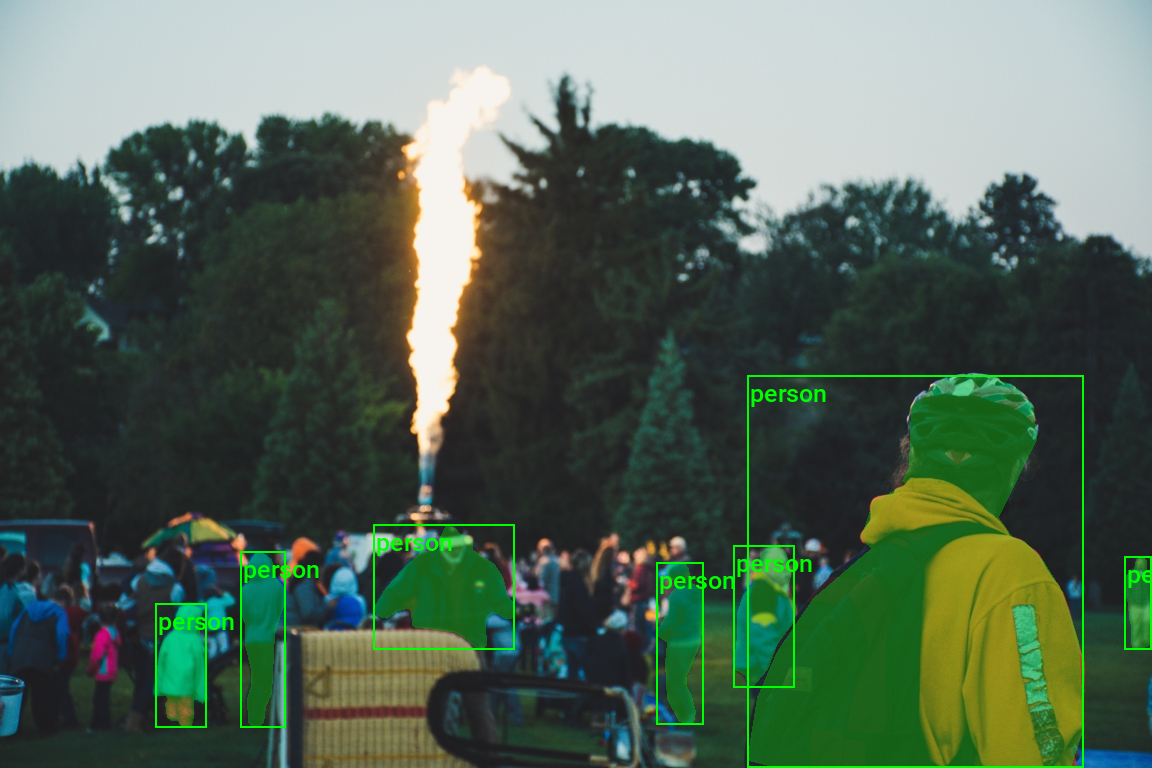

In [17]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = torchvision.ops.masks_to_boxes(masks)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=bboxes, 
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

## Preparing the Data

### Data Augmentation

#### Set training image size

In [18]:
# Set training image size
train_sz = 512

#### Initialize custom transforms

In [19]:
# Create a RandomIoUCrop object
iou_crop = CustomRandomIoUCrop(min_scale=0.3, 
                               max_scale=1.0, 
                               min_aspect_ratio=0.5, 
                               max_aspect_ratio=2.0, 
                               sampler_options=[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                               trials=400, 
                               jitter_factor=0.25)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=0)

#### Test the transforms

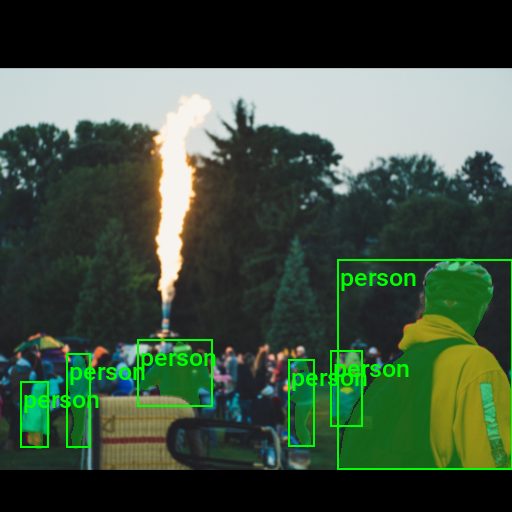

Source Image:,"(1152, 768)"
Cropped Image:,"(957, 750)"
Resized Image:,"(511, 401)"
Padded Image:,"(511, 511)"
Resized Padded Image:,"(512, 512)"


In [20]:
# Extract the labels for the sample
labels = [shape['label'] for shape in annotation_df.loc[file_id]['shapes']]
# Extract the polygon points for segmentation mask
shape_points = [shape['points'] for shape in annotation_df.loc[file_id]['shapes']]
# Format polygon points for PIL
xy_coords = [[tuple(p) for p in points] for points in shape_points]
# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, xy) for xy in xy_coords]
# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])
# Generate bounding box annotations from segmentation masks
bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=sample_img.size[::-1])

# Get colors for dataset sample
sample_colors = [int_colors[i] for i in [class_names.index(label) for label in labels]]

# Prepare mask and bounding box targets
targets = {
    'masks': Mask(masks), 
    'boxes': bboxes, 
    'labels': torch.Tensor([class_names.index(label) for label in labels])
}

# Crop the image
cropped_img, targets = iou_crop(sample_img, targets)

# Resize the image
resized_img, targets = resize_max(cropped_img, targets)

# Pad the image
padded_img, targets = pad_square(resized_img, targets)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img, targets = resize(padded_img, targets)
sanitized_img, targets = transforms.SanitizeBoundingBoxes()(resized_padded_img, targets)

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sanitized_img), 
    masks=targets['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=targets['boxes'], 
    labels=[class_names[int(label.item())] for label in targets['labels']], 
    colors=sample_colors
)

# # Display the annotated image
display(tensor_to_pil(annotated_tensor))

pd.Series({
    "Source Image:": sample_img.size,
    "Cropped Image:": cropped_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [21]:
class LabelMeInstSegDataset(Dataset):
    """
    A PyTorch Dataset class for handling LabelMe instance segmentation data.

    Attributes:
        _img_keys (list): A list of image keys identifying the images.
        _annotation_df (DataFrame): A pandas DataFrame containing the annotations for each image.
        _img_dict (dict): A dictionary mapping image keys to their corresponding file paths.
        _class_to_idx (dict): A dictionary mapping class names to their respective indices.
        _transforms (callable, optional): A function/transform that takes in an image and its target
                                           and returns a transformed version.
    """

    def __init__(self, img_keys, annotation_df, img_dict, class_to_idx, transforms=None):
        """
        Initializes the LabelMeInstSegDataset object with images, annotations, and optional transforms.

        Args:
            img_keys (list): List of image keys.
            annotation_df (DataFrame): DataFrame with annotations for each image.
            img_dict (dict): Dictionary mapping image keys to image file paths.
            class_to_idx (dict): Dictionary mapping class names to class indices.
            transforms (callable, optional): Optional transforms to be applied on the images.
        """
        super(Dataset, self).__init__()
        
        self._img_keys = img_keys
        self._annotation_df = annotation_df
        self._img_dict = img_dict
        self._class_to_idx = class_to_idx
        self._transforms = transforms
        
    def __len__(self):
        """Returns the total number of items in the dataset."""
        return len(self._img_keys)
        
    def __getitem__(self, index):
        """
        Retrieves an image and its corresponding target (annotations) by index.

        Args:
            index (int): The index of the item.

        Returns:
            tuple: A tuple containing the image and its target (a dictionary with keys 'masks', 'boxes', 'labels').
        """
        img_key = self._img_keys[index]
        annotation = self._annotation_df.loc[img_key]
        image, target = self._load_image_and_target(annotation)
        
        if self._transforms:
            image, target = self._transforms(image, target)
        
        return image, target

    def _load_image_and_target(self, annotation):
        """
        Loads an image and its corresponding target data based on the given annotation.

        Args:
            annotation (DataFrame row): The annotation row corresponding to an image.

        Returns:
            tuple: A tuple containing the image and its target (a dictionary with keys 'masks', 'boxes', 'labels').
        """
        filepath = self._img_dict[annotation.name]
        image = Image.open(filepath).convert('RGB')
        
        # Extract labels for each shape in the annotation and convert them to tensor
        labels = [shape['label'] for shape in annotation['shapes']]
        labels = torch.Tensor([self._class_to_idx[label] for label in labels])
        labels = labels.to(dtype=torch.int64)

        # Process shape points to create masks
        shape_points = [shape['points'] for shape in annotation['shapes']]
        xy_coords = [[tuple(p) for p in points] for points in shape_points]
        mask_imgs = [create_polygon_mask(image.size, xy) for xy in xy_coords]
        masks = Mask(torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs]))

        # Create bounding boxes from masks
        bboxes = BoundingBoxes(data=torchvision.ops.masks_to_boxes(masks), format='xyxy', canvas_size=image.size[::-1])

        return image, {'masks': masks, 'boxes': bboxes, 'labels': labels}

### Image Transforms

In [22]:
# Compose transforms for data augmentation
data_aug_tfms = transforms.Compose(
    transforms=[
        iou_crop,
        transforms.ColorJitter(
                brightness = (0.875, 1.125),
                contrast = (0.5, 1.5),
                saturation = (0.5, 1.5),
                hue = (-0.05, 0.05),
        ),
        transforms.RandomGrayscale(),
        transforms.RandomEqualize(),
        transforms.RandomPosterize(bits=3, p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
    ],
)

# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max, 
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(), 
    transforms.ToDtype(torch.float32, scale=True),
    transforms.SanitizeBoundingBoxes(),
])

# Define the transformations for training and validation datasets
train_tfms = transforms.Compose([
    data_aug_tfms, 
    resize_pad_tfm, 
    final_tfms
])

### Initialize Dataset

In [23]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = LabelMeInstSegDataset(list(img_dict.keys()), annotation_df, img_dict, class_to_idx, train_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
}).to_frame().style.hide(axis='columns')

Training dataset size:,31


### Inspect Samples

#### Inspect training set sample

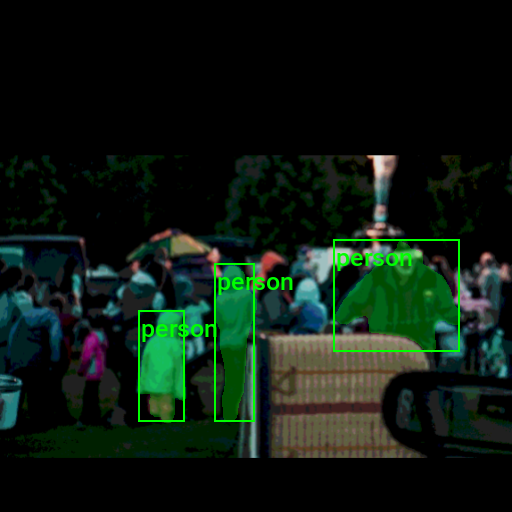

In [24]:
dataset_sample = train_dataset[0]

# Get colors for dataset sample
sample_colors = [int_colors[int(i.item())] for i in dataset_sample[1]['labels']]

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks( 
    image=(dataset_sample[0]*255).to(dtype=torch.uint8), 
    masks=dataset_sample[1]['masks'], 
    alpha=0.3, 
    colors=sample_colors
)

# Annotate the sample image with bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=dataset_sample[1]['boxes'], 
    labels=[class_names[int(i.item())] for i in dataset_sample[1]['labels']], 
    colors=sample_colors
)

tensor_to_pil(annotated_tensor)